# Day 04 — Logistic Regression Customer Churn Prediction Pipeline

Today’s goal:
- Build Logistic Regression churn model
- Use OneHotEncoder + StandardScaler
- Train + tune using GridSearchCV
- Evaluate with AUC & ROC
- Save best model for API/Dashboard use

## Step 1 — Install & Import Dependencies

We install required packages and import all necessary libraries for preprocessing, modeling, evaluation, and saving the trained model.

In [11]:
!pip install scikit-learn pandas numpy seaborn matplotlib joblib --quiet

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, RocCurveDisplay
import joblib,os

## Step 2 — Load Dataset

We load the Telco Customer Churn dataset used in Day 03 to ensure consistent comparison between multiple models (KNN vs Logistic Regression).

In [2]:
df = pd.read_csv("data/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Step 3 — Data Cleaning

Data preparation steps:
- Convert TotalCharges to numeric
- Remove rows with invalid entries
- Drop `customerID` because it does not contribute to prediction
- Split features (X) and target (y)

In [3]:
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df.dropna(inplace=True)
df = df.drop(columns=["customerID"])

X = df.drop("Churn", axis=1)
y = df["Churn"]
X.shape, y.shape

((7032, 19), (7032,))

## Step 4 — Build ML Pipeline

This pipeline automatically:
- Scales numeric values using StandardScaler
- Encodes categorical values using OneHotEncoder
- Trains Logistic Regression with consistent preprocessing

In [4]:
numeric = ["tenure", "MonthlyCharges", "TotalCharges"]
categorical = [c for c in X.columns if c not in numeric]

preprocessor = ColumnTransformer([
    ("numeric", StandardScaler(), numeric),
    ("categorical", OneHotEncoder(handle_unknown="ignore"), categorical)
])

pipeline = Pipeline([
    ("prep", preprocessor),
    ("logreg", LogisticRegression(max_iter=200))
])

pipeline

,steps,"[('prep', ...), ('logreg', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numeric', ...), ('categorical', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## Step 5 — Hyperparameter Tuning (GridSearchCV)

We test multiple Logistic Regression configurations with different:
- Penalty strengths (C values)
- Solvers (optimization methods)

Goal: find the highest validation-score model.

In [5]:
params = {
    "logreg__C": [0.1, 0.5, 1, 2, 5],
    "logreg__solver": ["liblinear", "lbfgs"]
}

grid = GridSearchCV(pipeline, params, cv=5, scoring="accuracy", n_jobs=-1)
grid.fit(X, y)

print("Best Parameters:", grid.best_params_)
print("Best Cross-Validation Accuracy:", round(grid.best_score_, 3))

best_model = grid.best_estimator_

Best Parameters: {'logreg__C': 5, 'logreg__solver': 'lbfgs'}
Best Cross-Validation Accuracy: 0.804


## Step 6 — Evaluate Model Performance

Metrics to analyze:
- Accuracy (overall performance)
- Precision, Recall, F1 (classification quality)
- Confusion Matrix (misclassification insight)

These metrics help validate the business usefulness of the churn model.

Accuracy: 0.7974971558589306

Classification Report:
               precision    recall  f1-score   support

          No       0.84      0.90      0.87      1300
         Yes       0.64      0.52      0.57       458

    accuracy                           0.80      1758
   macro avg       0.74      0.71      0.72      1758
weighted avg       0.79      0.80      0.79      1758



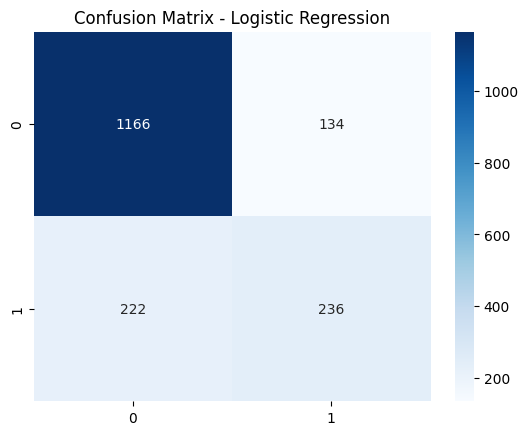

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
pred = best_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, pred))
print("\nClassification Report:\n", classification_report(y_test, pred))

cm = confusion_matrix(y_test, pred)
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

## Step 7 — Performance via ROC-AUC

We evaluate ROC-AUC because churn prediction depends on ranking probability — not just predicting classes.  
AUC measures how well the model ranks churn risk from high to low.

AUC Score: 0.8380668458179376


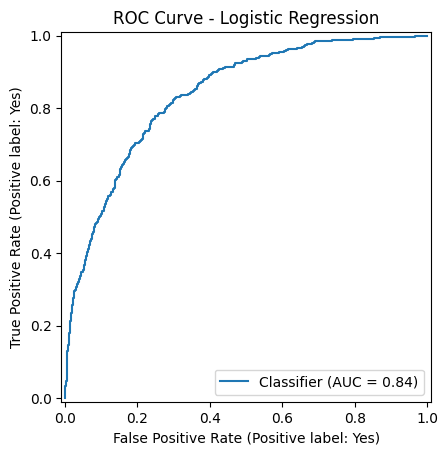

In [9]:
proba = best_model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, proba)
print("AUC Score:", auc)

RocCurveDisplay.from_predictions(y_test, proba, pos_label="Yes")
plt.title("ROC Curve - Logistic Regression")
plt.show()

## Step 8 — Export Model for Deployment

We save the trained model as `churn_logreg_model.pkl`.  
This file will be used by:
- FastAPI backend (`/predict` endpoint)
- Streamlit dashboard (model selection)
- Day 05 leaderboard comparison

In [13]:
os.makedirs("model", exist_ok=True)  

joblib.dump(best_model, "model/churn_logreg_model.pkl")
print("Model saved → model/churn_logreg_model.pkl")

Model saved → model/churn_logreg_model.pkl
